imports

In [1]:
import os
import re
import random
import joblib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
    roc_auc_score,
    log_loss,
    f1_score
)


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, logging

# keep notebook output clean
logging.set_verbosity_warning()
warnings.filterwarnings('ignore')


In [2]:
# !pip -q install transformers accelerate
# !pip -q install scikit-learn seaborn tqdm joblib transformers accelerate


seed and device

In [3]:
def set_seed(seed=42):
    # reproducibility - same random splits and similar training behavior
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # deterministic mode
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# use gpu when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")


using device: cuda


paths and config

In [4]:
# dataset folder on your machine
DATA_DIR = r"E:\Project_ML\Dataset"               
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv") # training file (has labels)
TEST_PATH = os.path.join(DATA_DIR, "test.csv")   # test file (no labels)

# auto-detect when running in colab
ALT_DIR = Path("/content")
if (ALT_DIR / "train.csv").exists() and (ALT_DIR / "test.csv").exists():
    TRAIN_PATH = str(ALT_DIR / "train.csv")
    TEST_PATH = str(ALT_DIR / "test.csv")

# where to save fitted vectorizers and trained models
MODELS_DIR = "models"

# column names in csv
TEXT_COL = "comment_text"          # raw text (original)
CLEAN_COL = "comment_clean"        # cleaned text for tf-idf
LABEL_COLS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
BINARY_TARGET = "is_toxic"         # derived binary label: 1 if any of the 6 labels is 1

# non-toxic as an extra multilabel target (redundant)
ADD_NON_TOXIC_AS_LABEL = False     # if true -> multilabel has 7 labels (6 + non_toxic)
NON_TOXIC_COL = "non_toxic"

# thresholds to convert probabilities into 0/1 predictions
BINARY_THRESHOLD = 0.5
MULTI_THRESHOLD = 0.5

# tf-idf parameters for binary model 
TFIDF_BINARY_PARAMS = dict(
    analyzer="char",          # "word" or "char"
    ngram_range=(3, 5),       # word: (1,2) is a good start; char: (3,5)
    max_features=200000,      # bigger usually improves results but uses more ram
    min_df=2,                 # ignore very rare terms
    max_df=0.95,              # ignore very common terms
    strip_accents="unicode",
    lowercase=False,          # cleaning already lowercases
    sublinear_tf=True,        # log scaling for term frequency
)

# tf-idf parameters for multilabel model 
TFIDF_MULTI_PARAMS = dict(
    analyzer="char",          # char n-grams are strong for toxic language
    ngram_range=(3, 5),
    max_features=200000,
    min_df=2,
    max_df=1.0,
    strip_accents="unicode",
    lowercase=False,
    sublinear_tf=True,
)

# logistic regression parameters for binary model 
LR_BINARY_PARAMS = dict(
    max_iter=2000,
    random_state=42,
    solver="liblinear",       # good for sparse tf-idf
    C=8.0,                    # regularization strength
    class_weight="balanced",  # helps for imbalanced binary labels
)

# logistic regression parameters for multilabel model (base estimator in one-vs-rest)
LR_MULTI_PARAMS = dict(
    max_iter=2000,
    random_state=42,
    solver="liblinear",
    C=16.0,
    class_weight="balanced",       
)

# distilbert training settings 
BATCH_SIZE = 16              # lower is safer on memory
EPOCHS = 10                  # for quick runs
LR = 2e-5                    # typical lr for distilbert
MAX_LEN = 128                # higher can help
WEIGHT_DECAY = 0.0
SAMPLE_N = 20000             # use subset for speed and None for full dataset

# robust check for file paths
if not os.path.exists(TRAIN_PATH) or not os.path.exists(TEST_PATH):
    raise FileNotFoundError(
        f"files not found. check TRAIN_PATH/TEST_PATH.\ntrain: {TRAIN_PATH}\ntest: {TEST_PATH}"
    )

# create output folder
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"artifacts will be saved to: {os.path.abspath(MODELS_DIR)}")

# names used for binary reports and plots
BINARY_CLASS_NAMES = ["non-toxic", "toxic"]

def plot_cm_binary(y_true, y_pred, class_names=BINARY_CLASS_NAMES, title="confusion matrix", cmap="Greens"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(title)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.tight_layout()
    plt.show()

def plot_cm_multilabel(y_true, y_pred, label_names, cmap="Purples", cols=3):
    cm_multi = multilabel_confusion_matrix(y_true, y_pred)
    n = len(label_names)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4.5 * rows))
    axes = np.array(axes).reshape(-1)

    for i, label in enumerate(label_names):
        tick = [f"not {label}", label]
        sns.heatmap(
            cm_multi[i],
            annot=True,
            fmt="d",
            cmap=cmap,
            xticklabels=tick,
            yticklabels=tick,
            ax=axes[i]
        )
        axes[i].set_title(f"label: {label}")
        axes[i].set_xlabel("predicted")
        axes[i].set_ylabel("actual")

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

def plot_training_curves(history, title_prefix="training"):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title(f"{title_prefix}: loss vs epochs")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="train")
    plt.plot(history["val_acc"], label="val")
    plt.title(f"{title_prefix}: accuracy vs epochs")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def format_predictions_binary(texts, preds, probs, class_names=BINARY_CLASS_NAMES, prob_name="p(toxic)"):
    preds = np.asarray(preds).astype(int)
    probs = np.asarray(probs).astype(float)
    return pd.DataFrame({
        "text": list(texts),
        "prediction": [class_names[p] for p in preds],
        prob_name: np.round(probs, 4)
    })

def format_predictions_multilabel(texts, probs, label_names, threshold=0.5):
    probs = np.asarray(probs).astype(float)
    preds = (probs >= threshold).astype(int)

    pred_labels = []
    for row in preds:
        active = [label_names[i] for i, v in enumerate(row) if v == 1]
        pred_labels.append(", ".join(active) if active else "(none)")

    out = pd.DataFrame({
        "text": list(texts),
        "prediction": pred_labels
    })

    for i, lbl in enumerate(label_names):
        out[f"p({lbl})"] = np.round(probs[:, i], 4)

    return out

def add_non_toxic_column(df, label_cols=LABEL_COLS, out_col=NON_TOXIC_COL):
    # non-toxic is 1 only when all toxic labels are 0 (fully determined by the 6 labels)
    df[out_col] = (df[label_cols].max(axis=1) == 0).astype(int)
    return df

def enforce_non_toxic_consistency(preds, label_names):
    # if you train with non-toxic label, this avoids contradictions
    # rule - if any toxic label is 1 => non_toxic must be 0
    if NON_TOXIC_COL not in label_names:
        return preds
    idx_non = label_names.index(NON_TOXIC_COL)
    toxic_idxs = [i for i, lbl in enumerate(label_names) if lbl != NON_TOXIC_COL]
    any_toxic = preds[:, toxic_idxs].max(axis=1)
    preds[:, idx_non] = (1 - any_toxic)
    return preds


artifacts will be saved to: e:\Project_ML\models


load data

In [5]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# check required columns in train
required_cols = [TEXT_COL] + LABEL_COLS
if not all(col in df_train.columns for col in required_cols):
    raise ValueError("missing required columns in train set")

# fill missing text values
df_train[TEXT_COL] = df_train[TEXT_COL].fillna("")
df_test[TEXT_COL] = df_test[TEXT_COL].fillna("")

print("train shape:", df_train.shape)
print("test shape:", df_test.shape)
print("\ntrain head:")
display(df_train.head(3))
print("\ntrain info:")
print(df_train.info())


train shape: (159571, 8)
test shape: (153164, 2)

train head:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0



train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


eda distributions

duplicate rows in train: 0

binary distribution:
is_toxic
0    143346
1     16225
Name: count, dtype: int64

binary pct:
is_toxic
0    89.832
1    10.168
Name: proportion, dtype: float64


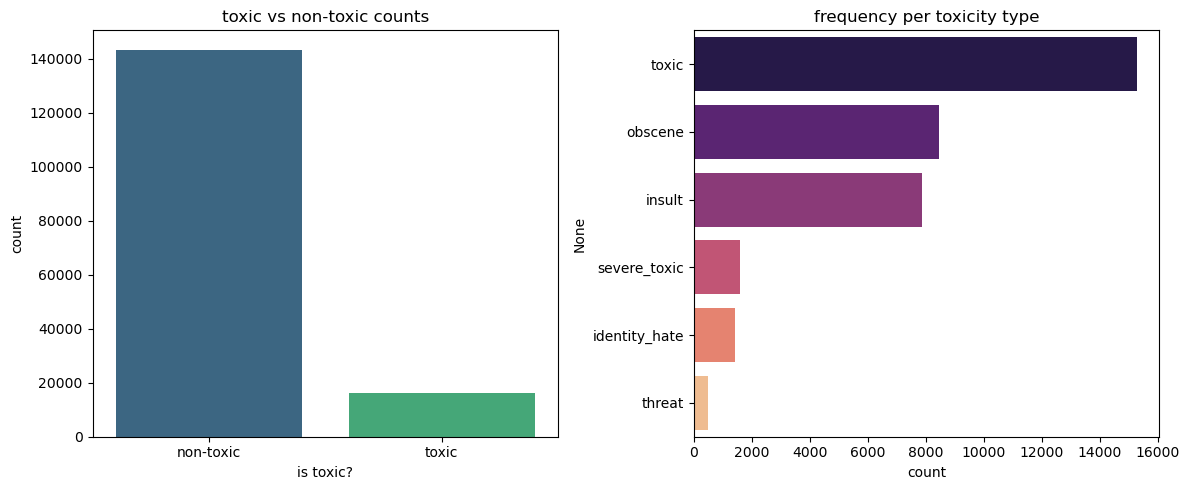


missing values per column:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
is_toxic         0
dtype: int64


In [6]:
dup_count = df_train.duplicated(subset=[TEXT_COL]).sum()
print(f"duplicate rows in train: {dup_count}")

# binary label derived from multilabel targets
df_train[BINARY_TARGET] = df_train[LABEL_COLS].max(axis=1).astype(int)

binary_counts = df_train[BINARY_TARGET].value_counts()
binary_pct = df_train[BINARY_TARGET].value_counts(normalize=True) * 100

print("\nbinary distribution:")
print(binary_counts)
print("\nbinary pct:")
print(np.round(binary_pct, 3))

label_counts = df_train[LABEL_COLS].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=binary_counts.index, y=binary_counts.values, palette='viridis')
plt.title("toxic vs non-toxic counts")
plt.xlabel("is toxic?")
plt.ylabel("count")
plt.xticks(ticks=[0, 1], labels=["non-toxic", "toxic"])

plt.subplot(1, 2, 2)
sns.barplot(x=label_counts.values, y=label_counts.index, palette='magma')
plt.title("frequency per toxicity type")
plt.xlabel("count")

plt.tight_layout()
plt.show()

print("\nmissing values per column:")
print(df_train.isnull().sum())


tf-idf text cleaning

In [7]:
def clean_text_tfidf(text):
    # this cleaning is designed for sparse models (tf-idf)
    # goal - normalize noise but keep useful word patterns
    text = "" if text is None else str(text)

    # lowercase for normalization
    text = text.lower()

    # replace urls with a token (keeps signal that a url existed)
    text = re.sub(r"(http\S+|www\.\S+)", " URL ", text)

    # remove html tags
    text = re.sub(r"<[^>]+>", " ", text)

    # normalize repeated punctuation (!!! -> !, ??? -> ?)
    text = re.sub(r"([!?\.])\1{2,}", r"\1", text)

    # normalize elongated words (soooo -> soo)
    text = re.sub(r"([a-z])\1{2,}", r"\1\1", text)

    # keep letters, digits, and basic punctuation
    text = re.sub(r"[^a-z0-9\s\.,!?\']", " ", text)

    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

print("cleaning train set for tf-idf...")
df_train[CLEAN_COL] = df_train[TEXT_COL].apply(clean_text_tfidf)
print("cleaning test set for tf-idf...")
df_test[CLEAN_COL] = df_test[TEXT_COL].apply(clean_text_tfidf)

print("\ncleaning examples (raw vs tf-idf clean):")
example_df = df_train[[TEXT_COL, CLEAN_COL]].head(5)
display(example_df)


cleaning train set for tf-idf...
cleaning test set for tf-idf...

cleaning examples (raw vs tf-idf clean):


,comment_text,comment_clean
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,d'aww! he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...","hey man, i'm really not trying to edit war. it..."
3,"""\nMore\nI can't make any real suggestions on ...",more i can't make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...","you, sir, are my hero. any chance you remember..."


binary split and tf-idf

In [8]:
print("preparing data for model 1...")

X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    df_train[CLEAN_COL],
    df_train[BINARY_TARGET],
    test_size=0.2,
    stratify=df_train[BINARY_TARGET],
    random_state=42
)

tfidf_b = TfidfVectorizer(**TFIDF_BINARY_PARAMS)
X_train_vec_b = tfidf_b.fit_transform(X_train_b)
X_val_vec_b = tfidf_b.transform(X_val_b)


preparing data for model 1...


train logistic regression binary

In [9]:
print("training logistic regression...")

lr_binary = LogisticRegression(**LR_BINARY_PARAMS)
lr_binary.fit(X_train_vec_b, y_train_b)


training logistic regression...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,8.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


evaluate logistic regression binary

In [10]:
y_pred_b = lr_binary.predict(X_val_vec_b)
y_prob_b = lr_binary.predict_proba(X_val_vec_b)[:, 1]

print("binary classical results:")
print(f"accuracy: {accuracy_score(y_val_b, y_pred_b):.4f}")
print(f"log loss: {log_loss(y_val_b, lr_binary.predict_proba(X_val_vec_b)):.4f}")
print(f"f1 macro: {f1_score(y_val_b, y_pred_b, average='macro'):.4f}")
print(f"roc-auc: {roc_auc_score(y_val_b, y_prob_b):.4f}")
print(classification_report(y_val_b, y_pred_b, target_names=BINARY_CLASS_NAMES, zero_division=0))

binary classical results:
accuracy: 0.9562
log loss: 0.1199
f1 macro: 0.8858
roc-auc: 0.9788
              precision    recall  f1-score   support

   non-toxic       0.98      0.97      0.98     28670
       toxic       0.76      0.84      0.80      3245

    accuracy                           0.96     31915
   macro avg       0.87      0.90      0.89     31915
weighted avg       0.96      0.96      0.96     31915



binary confusion matrix

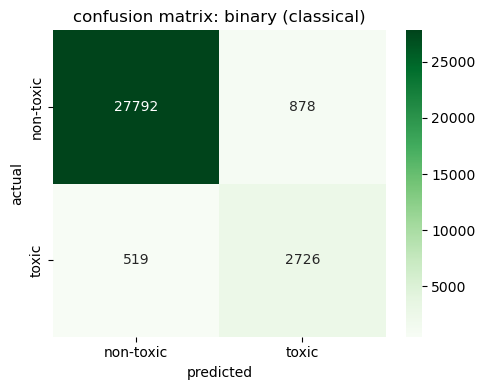

In [11]:
plot_cm_binary(
    y_val_b,
    y_pred_b,
    class_names=BINARY_CLASS_NAMES,
    title="confusion matrix: binary (classical)",
    cmap="Greens"
)


binary test samples

In [12]:
print("test predictions: ")
test_samples = df_test.sample(3, random_state=42)
test_vec = tfidf_b.transform(test_samples[CLEAN_COL])

test_preds = lr_binary.predict(test_vec)
test_probs = lr_binary.predict_proba(test_vec)[:, 1]

results_df = format_predictions_binary(
    texts=test_samples[TEXT_COL].values,
    preds=test_preds,
    probs=test_probs,
    class_names=BINARY_CLASS_NAMES,
    prob_name="p(toxic)"
)
display(results_df)


test predictions: 


,text,prediction,p(toxic)
0,"== Sky city == \n\n Hello, \n\n I noticed that...",non-toxic,0.0018
1,""" \n\n """"Specifically, Allied forces suffered ...",non-toxic,0.0016
2,""" \n You know what, I think you're just insecu...",non-toxic,0.1858


binary custom input

In [13]:
user_input = "you are extremely stupid and i hate this."
proc_input = clean_text_tfidf(user_input)
vec_input = tfidf_b.transform([proc_input])

cust_pred = lr_binary.predict(vec_input)[0]
cust_prob = lr_binary.predict_proba(vec_input)[0][1]

print("custom input prediction: ")
display(format_predictions_binary(
    texts=[user_input],
    preds=[cust_pred],
    probs=[cust_prob],
    class_names=BINARY_CLASS_NAMES,
    prob_name="p(toxic)"
))


custom input prediction: 


,text,prediction,p(toxic)
0,you are extremely stupid and i hate this.,toxic,1.0


save binary artifacts

In [14]:
joblib.dump(tfidf_b, os.path.join(MODELS_DIR, "tfidf_binary.pkl"))
joblib.dump(lr_binary, os.path.join(MODELS_DIR, "lr_binary.pkl"))
print("model 1 saved.")


model 1 saved.


multilabel split and tf-idf

In [15]:
print("preparing data for model 2...")

label_cols_multi = LABEL_COLS.copy()
if ADD_NON_TOXIC_AS_LABEL:
    df_train = add_non_toxic_column(df_train, LABEL_COLS, NON_TOXIC_COL)
    label_cols_multi = LABEL_COLS + [NON_TOXIC_COL]

X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(
    df_train[CLEAN_COL],
    df_train[label_cols_multi],
    test_size=0.2,
    stratify=df_train[BINARY_TARGET],
    random_state=42
)

tfidf_m = TfidfVectorizer(**TFIDF_MULTI_PARAMS)
X_train_vec_m = tfidf_m.fit_transform(X_train_m)
X_val_vec_m = tfidf_m.transform(X_val_m)


preparing data for model 2...


train one-vs-rest logistic regression

In [16]:
print("training onevsrest logistic regression...")

base_lr = LogisticRegression(**LR_MULTI_PARAMS)
ovr_lr = OneVsRestClassifier(base_lr)
ovr_lr.fit(X_train_vec_m, y_train_m)


training onevsrest logistic regression...


,estimator,LogisticRegre...r='liblinear')
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,16.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42


evaluate one-vs-rest multilabel

In [17]:
y_prob_m = ovr_lr.predict_proba(X_val_vec_m)
y_pred_m = (y_prob_m >= MULTI_THRESHOLD).astype(int)

# if non-toxic is included -> keep predictions consistent
y_pred_m = enforce_non_toxic_consistency(y_pred_m, list(y_train_m.columns))

subset_acc = accuracy_score(y_val_m, y_pred_m)

# f1 scores for multilabel
f1_micro = f1_score(y_val_m, y_pred_m, average="micro", zero_division=0)
f1_macro = f1_score(y_val_m, y_pred_m, average="macro", zero_division=0)

# multilabel log loss: compute per label, then average
# y_val_m must be 0/1 and y_prob_m must be probabilities in [0,1]
ll_per_label = []
for j in range(y_prob_m.shape[1]):
    ll_per_label.append(log_loss(y_val_m.iloc[:, j], y_prob_m[:, j], labels=[0, 1]))
logloss_macro = float(np.mean(ll_per_label))

print(f"subset accuracy: {subset_acc:.4f}")
print(f"log loss: {logloss_macro:.4f}")
print(f"f1 micro: {f1_micro:.4f}")
print(f"f1 macro: {f1_macro:.4f}")
print(f"roc-auc micro: {roc_auc_score(y_val_m, y_prob_m, average='micro'):.4f}")
print(f"roc-auc macro: {roc_auc_score(y_val_m, y_prob_m, average='macro'):.4f}")
print("classification report:")
print(classification_report(y_val_m, y_pred_m, target_names=list(y_train_m.columns), zero_division=0))


subset accuracy: 0.9094
log loss: 0.0594
f1 micro: 0.7466
f1 macro: 0.6374
roc-auc micro: 0.9867
roc-auc macro: 0.9826
classification report:
               precision    recall  f1-score   support

        toxic       0.75      0.82      0.78      3046
 severe_toxic       0.39      0.64      0.49       305
      obscene       0.80      0.83      0.81      1662
       threat       0.47      0.59      0.52        98
       insult       0.68      0.80      0.73      1576
identity_hate       0.41      0.59      0.48       259

    micro avg       0.70      0.80      0.75      6946
    macro avg       0.58      0.71      0.64      6946
 weighted avg       0.71      0.80      0.75      6946
  samples avg       0.07      0.07      0.07      6946



multilabel confusion matrices

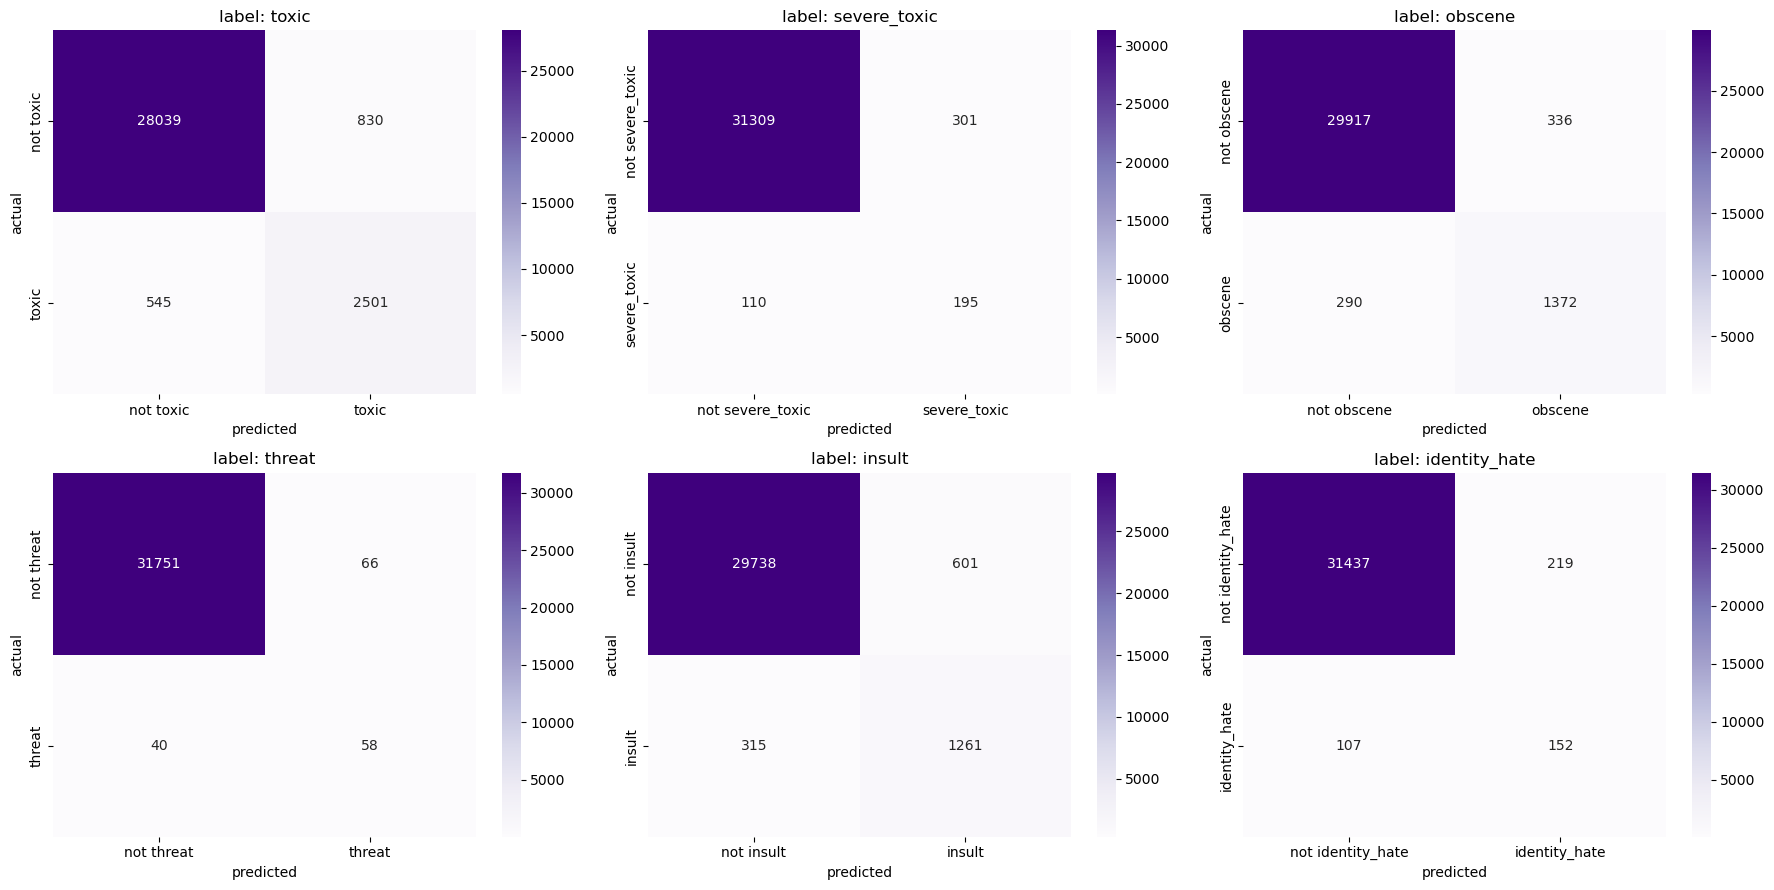

In [18]:
plot_cm_multilabel(
    y_val_m.values,
    y_pred_m,
    label_names=list(y_train_m.columns),
    cmap="Purples",
    cols=3
)


multilabel test samples

In [19]:
print("test predictions: ")
test_samples = df_test.sample(3, random_state=42)
test_vec = tfidf_m.transform(test_samples[CLEAN_COL])

test_probs = ovr_lr.predict_proba(test_vec)

results_df = format_predictions_multilabel(
    texts=test_samples[TEXT_COL].values,
    probs=test_probs,
    label_names=list(y_train_m.columns),
    threshold=MULTI_THRESHOLD
)
display(results_df)


test predictions: 


,text,prediction,p(toxic),p(severe_toxic),p(obscene),p(threat),p(insult),p(identity_hate)
0,"== Sky city == \n\n Hello, \n\n I noticed that...",(none),0.0002,0.0004,0.0009,0.0015,0.0001,0.0003
1,""" \n\n """"Specifically, Allied forces suffered ...",(none),0.0007,0.0001,0.0027,0.0023,0.0027,0.0005
2,""" \n You know what, I think you're just insecu...",(none),0.0360,0.0063,0.0040,0.0002,0.0824,0.0005


multilabel custom input

In [20]:
user_input = "i will kill you."
print("custom input prediction: ")

proc_input = clean_text_tfidf(user_input)
vec_input = tfidf_m.transform([proc_input])
cust_probs = ovr_lr.predict_proba(vec_input)

display(format_predictions_multilabel(
    texts=[user_input],
    probs=cust_probs,
    label_names=list(y_train_m.columns),
    threshold=MULTI_THRESHOLD
))


custom input prediction: 


,text,prediction,p(toxic),p(severe_toxic),p(obscene),p(threat),p(insult),p(identity_hate)
0,i will kill you.,"toxic, threat",1.0,0.0174,0.1311,1.0,0.0377,0.0748


save multilabel artifacts

In [21]:
joblib.dump(tfidf_m, os.path.join(MODELS_DIR, "tfidf_multi.pkl"))
joblib.dump(ovr_lr, os.path.join(MODELS_DIR, "ovr_lr.pkl"))
print("model 2 saved.")


model 2 saved.


distilbert binary data (raw text)

In [22]:
print("preparing data for model 3...")

# sampling is useful for fast experiments
df_sub = df_train.sample(SAMPLE_N, random_state=42) if SAMPLE_N else df_train

# important - bert uses original raw text
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(
    df_sub[TEXT_COL],
    df_sub[BINARY_TARGET],
    test_size=0.2,
    stratify=df_sub[BINARY_TARGET],
    random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # bert works best on original text
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_ds = ToxicDataset(X_train_d, y_train_d, tokenizer)
val_ds = ToxicDataset(X_val_d, y_val_d, tokenizer)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# imbalance handling - binary
# compute class weights from training split
counts = y_train_d.value_counts().sort_index()  # index: 0, 1
w0 = len(y_train_d) / (2 * counts.get(0, 1))
w1 = len(y_train_d) / (2 * counts.get(1, 1))
class_weights = torch.tensor([w0, w1], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

print("class counts:", dict(counts))
print("class weights:", class_weights.detach().cpu().numpy())


preparing data for model 3...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


class counts: {0: 14402, 1: 1598}
class weights: [0.5554784 5.006258 ]


distilbert binary training

training distilbert (binary)...


epoch 1/10: 100%|██████████| 1000/1000 [02:00<00:00,  8.31it/s]


val acc: 0.9357


epoch 2/10: 100%|██████████| 1000/1000 [02:01<00:00,  8.26it/s]


val acc: 0.9493


epoch 3/10: 100%|██████████| 1000/1000 [02:00<00:00,  8.28it/s]


val acc: 0.9455


epoch 4/10: 100%|██████████| 1000/1000 [02:01<00:00,  8.26it/s]


val acc: 0.9493


epoch 5/10: 100%|██████████| 1000/1000 [02:00<00:00,  8.27it/s]


val acc: 0.9193


epoch 6/10: 100%|██████████| 1000/1000 [02:00<00:00,  8.28it/s]


val acc: 0.9217


epoch 7/10: 100%|██████████| 1000/1000 [02:00<00:00,  8.28it/s]


val acc: 0.9493


epoch 8/10: 100%|██████████| 1000/1000 [02:01<00:00,  8.26it/s]


val acc: 0.9585


epoch 9/10: 100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]   


val acc: 0.9425


epoch 10/10: 100%|██████████| 1000/1000 [02:00<00:00,  8.29it/s]


val acc: 0.9583


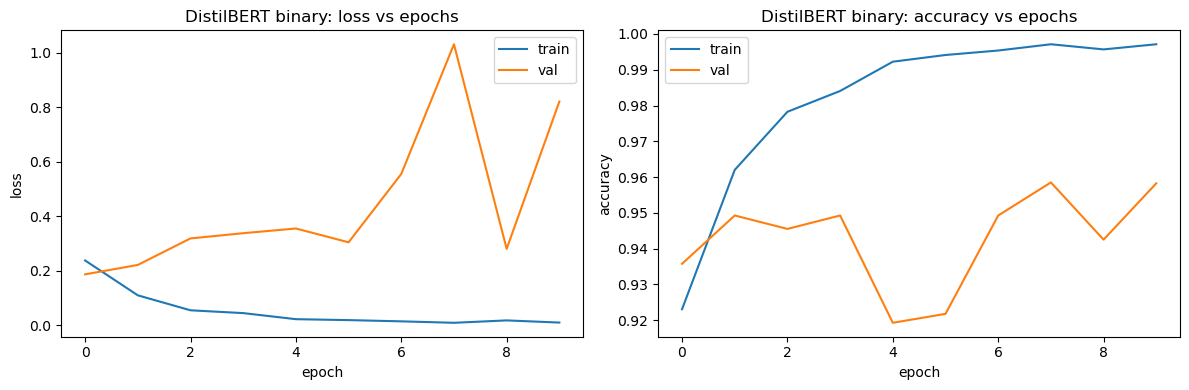

In [23]:
print("training distilbert (binary)...")
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc=f"epoch {epoch+1}/{EPOCHS}"):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        # forward WITHOUT labels -> we compute weighted loss ourselves
        outputs = model(ids, attention_mask=mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    history["train_loss"].append(total_loss / len(train_loader))
    history["train_acc"].append(correct / total if total else 0.0)

    # validation
    model.eval()
    val_loss = 0.0
    v_correct = 0
    v_total = 0

    with torch.no_grad():
        for batch in val_loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(ids, attention_mask=mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)

    history["val_loss"].append(val_loss / len(val_loader))
    history["val_acc"].append(v_correct / v_total if v_total else 0.0)
    print(f"val acc: {history['val_acc'][-1]:.4f}")

plot_training_curves(history, title_prefix="DistilBERT binary")


distilbert binary evaluation

In [24]:
print("binary deep learning results:")

all_preds = []
all_labels = []
all_scores = []
all_losses = []
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for batch in val_loader:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(ids, attention_mask=mask)
        logits = outputs.logits

        # weighted loss
        loss = criterion(logits, labels)

        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_losses.append(loss.item())
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(probs.cpu().numpy())

val_loss = float(np.mean(all_losses))
val_acc = correct / total if total else 0.0
f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"accuracy: {val_acc:.4f}")
print(f"loss: {val_loss:.4f}")
print(f"f1 macro: {f1_macro:.4f}")
print(f"roc-auc: {roc_auc_score(all_labels, all_scores):.4f}")
print(classification_report(all_labels, all_preds, target_names=BINARY_CLASS_NAMES, zero_division=0))


binary deep learning results:
accuracy: 0.9583
loss: 0.8208
f1 macro: 0.8796
roc-auc: 0.9672
              precision    recall  f1-score   support

   non-toxic       0.97      0.98      0.98      3601
       toxic       0.82      0.75      0.78       399

    accuracy                           0.96      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.96      0.96      0.96      4000



distilbert binary confusion matrix

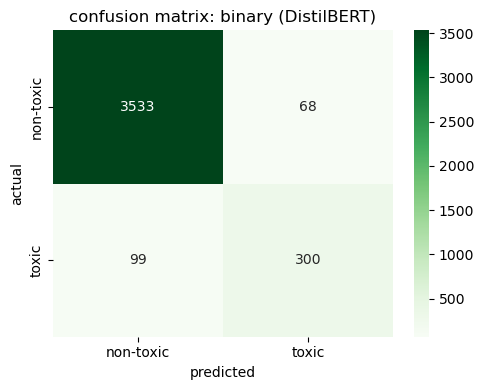

In [25]:
plot_cm_binary(
    all_labels,
    all_preds,
    class_names=BINARY_CLASS_NAMES,
    title="confusion matrix: binary (DistilBERT)",
    cmap="Greens"
)


distilbert binary test samples (raw text)

In [26]:
print("test predictions: ")
test_samples = df_test.sample(3, random_state=42)

model.eval()
bert_preds = []
bert_probs = []

with torch.no_grad():
    for txt in test_samples[TEXT_COL].values:
        # bert uses raw text
        inputs = tokenizer(str(txt), return_tensors="pt", truncation=True, padding=True).to(device)
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
        bert_probs.append(float(probs[1]))       # p(toxic)
        bert_preds.append(int(np.argmax(probs))) # 0/1

results_df = format_predictions_binary(
    texts=test_samples[TEXT_COL].values,
    preds=bert_preds,
    probs=bert_probs,
    class_names=BINARY_CLASS_NAMES,
    prob_name="p(toxic)"
)
display(results_df)


test predictions: 


,text,prediction,p(toxic)
0,"== Sky city == \n\n Hello, \n\n I noticed that...",non-toxic,0.0001
1,""" \n\n """"Specifically, Allied forces suffered ...",non-toxic,0.0000
2,""" \n You know what, I think you're just insecu...",non-toxic,0.0000


distilbert binary custom input (raw text)

In [27]:
user_input = "you are amazing!"
print("custom input prediction: ")

inputs = tokenizer(str(user_input), return_tensors="pt", truncation=True, padding=True).to(device)
model.eval()
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    pred_idx = int(np.argmax(probs))
    prob_toxic = float(probs[1])

display(format_predictions_binary(
    texts=[user_input],
    preds=[pred_idx],
    probs=[prob_toxic],
    class_names=BINARY_CLASS_NAMES,
    prob_name="p(toxic)"
))


custom input prediction: 


,text,prediction,p(toxic)
0,you are amazing!,non-toxic,0.0009


save distilbert binary

In [28]:
model.save_pretrained(os.path.join(MODELS_DIR, "distilbert_binary"))
tokenizer.save_pretrained(os.path.join(MODELS_DIR, "distilbert_binary"))
print("model 3 saved.")


model 3 saved.


distilbert multilabel data (raw text)

In [29]:
print("preparing data for model 4...")

df_sub_m = df_train.sample(SAMPLE_N, random_state=42) if SAMPLE_N else df_train

label_cols_bert = LABEL_COLS.copy()
if ADD_NON_TOXIC_AS_LABEL:
    df_sub_m = add_non_toxic_column(df_sub_m, LABEL_COLS, NON_TOXIC_COL)
    label_cols_bert = LABEL_COLS + [NON_TOXIC_COL]

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True).values.astype(np.float32)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # bert uses raw text
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.float)  # float for bce
        }

# important - split uses original text column
X_train_dm, X_val_dm, y_train_dm, y_val_dm = train_test_split(
    df_sub_m[TEXT_COL],
    df_sub_m[label_cols_bert],
    test_size=0.2,
    stratify=df_sub_m[BINARY_TARGET],
    random_state=42
)

train_ds_m = MultiLabelDataset(X_train_dm, y_train_dm, tokenizer)
val_ds_m = MultiLabelDataset(X_val_dm, y_val_dm, tokenizer)

train_loader_m = DataLoader(train_ds_m, batch_size=BATCH_SIZE, shuffle=True)
val_loader_m = DataLoader(val_ds_m, batch_size=BATCH_SIZE)

model_m = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_cols_bert),
    problem_type="multi_label_classification"
).to(device)

optimizer_m = AdamW(model_m.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# imbalance handling - multi-label
# pos_weight[j] = neg_count[j] / pos_count[j]
pos_counts = y_train_dm.sum(axis=0).values.astype(np.float32)          # shape (n_labels,)
neg_counts = (len(y_train_dm) - pos_counts).astype(np.float32)

# avoid division by zero if a label has 0 positives in train
pos_counts = np.clip(pos_counts, 1.0, None)

pos_weight = torch.tensor(neg_counts / pos_counts, dtype=torch.float).to(device)
criterion_m = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("pos counts:", dict(zip(label_cols_bert, y_train_dm.sum(axis=0).tolist())))
print("pos_weight:", pos_weight.detach().cpu().numpy())


preparing data for model 4...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pos counts: {'toxic': 1511, 'severe_toxic': 135, 'obscene': 836, 'threat': 31, 'insult': 790, 'identity_hate': 161}
pos_weight: [  9.589014 117.51852   18.138756 515.129     19.253164  98.37888 ]


distilbert multilabel training

In [ ]:
print("training distilbert (multi-label)...")

history_m = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
threshold = MULTI_THRESHOLD

for epoch in range(EPOCHS):
    model_m.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(train_loader_m, desc=f"epoch {epoch+1}/{EPOCHS}"):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # float

        optimizer_m.zero_grad()

        # forward WITHOUT labels -> we compute weighted bce ourselves
        outputs = model_m(ids, attention_mask=mask)
        logits = outputs.logits
        loss = criterion_m(logits, labels)

        loss.backward()
        optimizer_m.step()

        total_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).int()
        y_true = labels.int()

        if ADD_NON_TOXIC_AS_LABEL:
            preds_np = preds.detach().cpu().numpy()
            preds_np = enforce_non_toxic_consistency(preds_np, label_cols_bert)
            preds = torch.tensor(preds_np, device=preds.device, dtype=torch.int)

        correct += (preds == y_true).all(dim=1).sum().item()
        total += labels.size(0)

    history_m["train_loss"].append(total_loss / len(train_loader_m))
    history_m["train_acc"].append(correct / total if total else 0.0)
    print(f"train loss: {history_m['train_loss'][-1]:.4f} | train acc: {history_m['train_acc'][-1]:.4f}")

    # validation
    model_m.eval()
    val_loss = 0.0
    v_correct = 0
    v_total = 0

    with torch.no_grad():
        for batch in val_loader_m:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model_m(ids, attention_mask=mask)
            logits = outputs.logits
            loss = criterion_m(logits, labels)

            val_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).int()
            y_true = labels.int()

            if ADD_NON_TOXIC_AS_LABEL:
                preds_np = preds.detach().cpu().numpy()
                preds_np = enforce_non_toxic_consistency(preds_np, label_cols_bert)
                preds = torch.tensor(preds_np, device=preds.device, dtype=torch.int)

            v_correct += (preds == y_true).all(dim=1).sum().item()
            v_total += labels.size(0)

    history_m["val_loss"].append(val_loss / len(val_loader_m))
    history_m["val_acc"].append(v_correct / v_total if v_total else 0.0)
    print(f"val loss: {history_m['val_loss'][-1]:.4f} | val acc: {history_m['val_acc'][-1]:.4f}")

plot_training_curves(history_m, title_prefix="DistilBERT multi-label")


training distilbert (multi-label)...


epoch 1/10: 100%|██████████| 1000/1000 [02:01<00:00,  8.20it/s]


train loss: 0.5287 | train acc: 0.7931
val loss: 0.3533 | val acc: 0.8173


epoch 2/10: 100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


train loss: 0.2795 | train acc: 0.8561
val loss: 0.3173 | val acc: 0.7945


epoch 3/10:  27%|██▋       | 274/1000 [00:44<01:52,  6.47it/s]

distilbert multilabel evaluation

In [ ]:
print("multilabel deep learning results:")

all_preds_m = []
all_labels_m = []
all_probs_m = []
all_losses_m = []
correct = 0
total = 0

model_m.eval()
threshold = MULTI_THRESHOLD

with torch.no_grad():
    for batch in val_loader_m:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # float

        outputs = model_m(ids, attention_mask=mask)
        logits = outputs.logits

        # weighted loss
        loss = criterion_m(logits, labels)

        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).int()

        all_losses_m.append(loss.item())

        if ADD_NON_TOXIC_AS_LABEL:
            preds_np = preds.detach().cpu().numpy()
            preds_np = enforce_non_toxic_consistency(preds_np, label_cols_bert)
            preds = torch.tensor(preds_np, device=preds.device, dtype=torch.int)

        correct += (preds == labels.int()).all(dim=1).sum().item()
        total += labels.size(0)

        all_preds_m.extend(preds.cpu().numpy())
        all_labels_m.extend(labels.cpu().numpy())
        all_probs_m.extend(probs.cpu().numpy())

val_loss = float(np.mean(all_losses_m))
val_acc = correct / total if total else 0.0
f1_micro = f1_score(all_labels_m, all_preds_m, average="micro", zero_division=0)
f1_macro = f1_score(all_labels_m, all_preds_m, average="macro", zero_division=0)

print(f"subset accuracy: {val_acc:.4f}")
print(f"loss: {val_loss:.4f}")
print(f"f1 micro: {f1_micro:.4f}")
print(f"f1 macro: {f1_macro:.4f}")
print(f"roc-auc micro: {roc_auc_score(all_labels_m, all_probs_m, average='micro'):.4f}")
print(f"roc-auc macro: {roc_auc_score(all_labels_m, all_probs_m, average='macro'):.4f}")
print(classification_report(all_labels_m, all_preds_m, target_names=label_cols_bert, zero_division=0))


distilbert multilabel confusion matrices

In [ ]:
plot_cm_multilabel(
    np.array(all_labels_m),
    np.array(all_preds_m),
    label_names=label_cols_bert,
    cmap="Purples",
    cols=3
)


distilbert multilabel test samples (raw text)

In [ ]:
print("test predictions: ")
test_samples = df_test.sample(3, random_state=42)

model_m.eval()
all_probs = []

with torch.no_grad():
    for txt in test_samples[TEXT_COL].values:
        inputs = tokenizer(str(txt), return_tensors="pt", truncation=True, padding=True).to(device)
        logits = model_m(**inputs).logits
        probs = torch.sigmoid(logits)[0].detach().cpu().numpy()
        all_probs.append(probs)

results_df = format_predictions_multilabel(
    texts=test_samples[TEXT_COL].values,
    probs=np.vstack(all_probs),
    label_names=label_cols_bert,
    threshold=MULTI_THRESHOLD
)
display(results_df)


distilbert multilabel custom input (raw text)

In [ ]:
user_input = "you are stupid and ugly"
print("custom input prediction: ")

inputs = tokenizer(str(user_input), return_tensors="pt", truncation=True, padding=True).to(device)
model_m.eval()
with torch.no_grad():
    logits = model_m(**inputs).logits
    probs = torch.sigmoid(logits)[0].detach().cpu().numpy().reshape(1, -1)

display(format_predictions_multilabel(
    texts=[user_input],
    probs=probs,
    label_names=label_cols_bert,
    threshold=MULTI_THRESHOLD
))


save distilbert multilabel

In [ ]:
model_m.save_pretrained(os.path.join(MODELS_DIR, "distilbert_multi"))
tokenizer.save_pretrained(os.path.join(MODELS_DIR, "distilbert_multi"))
print("model 4 saved.")
